# PD6: Prediction of the Release Year of a Song
## MTI850 - Big Data Analytics
### Fall 2020


<br>
<br>    
    
| Étudiant | Xiaoang Zheng ZHEX21029701                                   |
|----------|---------------------------------------------------------|

<br>
<br>

![Spark Logo](http://alekoe.github.io/images/ta_Spark-logo-small.png) ![Python Logo](http://alekoe.github.io/images/python-logo-master-v3-TM-flattened_small.png)



This assignment covers a common supervised learning pipeline, using a subset of the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). Our goal is to train a linear regression model to predict the release year of a song given a set of audio features. The subset has 6,724 samples out of 515,345 in the original dataset.


**This assignment will cover:**

*  *Part 1:* Read and parse the initial dataset
  * *Visualization 1:* Features
  * *Visualization 2:* Shifting labels

*  *Part 2:* Create and evaluate a baseline model
  * *Visualization 3:* Predicted vs. actual

*  *Part 3:* Train (via gradient descent) and evaluate a linear regression model
  * *Visualization 4:* Training error

*  *Part 4:* Train using SparkML library and tune hyperparameters via grid search
  * *Visualization 5:* Best model's predictions
  * *Visualization 6:* Hyperparameter heat map

*  *Part 5:* Add interactions between features

> Note that, for reference, you can look up the details of:
> * the relevant Spark methods in [Spark's RDD Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and [Spark's DataFrame Python API](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame)
> * the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

## Part 0: Preparing the enviroment

<!-- By default, when a shuffle operation occurs with DataFrames, the post-shuffle partition count is 200. This is controlled by Spark configuration value ``spark.sql.shuffle.partitions``. 200 is a little too high for this data set, so we set the post-shuffle partition count to twice the number of available threads in Community Edition. -->

In [1]:
import os
import findspark
findspark.init()

# Test module for MTI850
import testmti850

# Util module for MTI850
import utilmti850

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
.master("local") \
.appName("Music Year Prediction") \
.getOrCreate()

## Part 1: Read and parse the initial dataset

### (1a) Download, load, and check the data

The raw data is currently stored in a text file. Let's download it from Moodle and make it available in the hdfs filesystem.
```
start-dfs.sh && start-yarn.sh
hdfs dfs -put millionsong.txt /millionsong.txt
```

Then, we will store this raw data in as a DataFrame, with each element of the DataFrame representing a data point as a comma-delimited string. Each string starts with the label (a year) followed by numerical audio features. Use the DataFrame [count method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.count) to check how many data points we have. Then use the [take method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.take) to create and print out a list of the first 5 data points in their initial string format.

In [2]:
raw_data_df = spark.read.text("./millionsong.txt")

raw_data_df.show(5)

+--------------------+
|               value|
+--------------------+
|2001.0,0.88412373...|
|2001.0,0.85441194...|
|2001.0,0.90898297...|
|2001.0,0.84252521...|
|2001.0,0.90930328...|
+--------------------+
only showing top 5 rows



In [3]:
# TODO: Replace <FILL IN> with appropriate code

num_points = raw_data_df.count()
print(num_points)

sample_points = raw_data_df.take(5)
print(sample_points)

6724
[Row(value='2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817'), Row(value='2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624'), Row(value='2001.0,0.908982970575,0.632063159227,0.557428975183,0.498263761394,0.276396052336,0.312809861625,0.448530069406,0.448674249968,0.649791323916,0.489868662682,0.591908113534,0.4500023818'), Row(value='2001.0,0.842525219898,0.561826888508,0.508715259692,0.443531142139,0.296733836002,0.250213568176,0.488540873206,0.360508747659,0.575435243185,0.361005878554,0.678378718617,0.409036786173'), Row(value='2001.0,0.909303285534,0.653607720915,0.585580794716,0.473250503005,0.251417011835,0.326976795524,0.40432273022,0.371154511756,0.629401917965,0.482243251755,0.566901413923,0.4633736919

In [4]:
# TEST Load and check the data (1a)
testmti850.Test.assertEquals(num_points, 6724, 'incorrect value for num_points')
testmti850.Test.assertEquals(len(sample_points), 5, 'incorrect length for sample_points')

1 test passed.
1 test passed.


### (1b) Using `LabeledPoint`

In MLlib, labeled training instances are stored using the [LabeledPoint](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) object.  Write the `parse_points` function that takes, as input, a DataFrame of comma-separated strings. We'll pass it the `raw_data_df` DataFrame.

It should parse each row in the DataFrame into individual elements, using Spark's [select](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.select) and [split](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.split) methods.

For example, split `"2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419"` into `['2001.0', '0.884', '0.610', '0.600', '0.474', '0.247', '0.357', '0.344', '0.33', '0.600', '0.425', '0.60', '0.419']`.

The first value in the resulting list (`2001.0` in the example, above) is the label. The remaining values (`0.884`, `0.610`, etc., in the example) are the features.

After splitting each row, map it to a `LabeledPoint`. You'll have to step down to an RDD (using `.rdd`) or use a DataFrame user-defined function to convert to the `LabeledPoint` object. (See **Hint**, below.) If you step down to an RDD, you'll have to use [toDF()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.toDF) to convert back to a DataFrame.

Use this new `parse_points` function to parse `raw_data_df`.  Then print out the features and label for the first training point, using the `features` and `label` attributes. Finally, calculate the number of features for this dataset.

## Hint: Running Arbitrary Lambdas on a DataFrame

To solve this problem, you need a way to run your `parse_points` function on a DataFrame. There are two ways to do this, which we will illustrate with an extremely simple example.

Suppose you have a DataFrame consisting of a first name and a last name, and you want to add a unique [SHA-256](https://en.wikipedia.org/wiki/Secure_Hash_Algorithm) hash to each row.

```
df = spark.createDataFrame([("John", "Smith"), ("Ravi", "Singh"), ("Julia", "Jones")], ("first_name", "last_name"))
```

Here's a simple function to calculate such a hash, using Python's built-in `hashlib` library:

```
def make_hash(first_name, last_name):
    import hashlib
    m = hashlib.sha256()
    # Join the first name and last name by a blank and hash the resulting
    # string.
    full_name = ' '.join((first_name, last_name))
    m.update(full_name)
    return m.hexdigest()
```

Okay, that's great. But, how do we use it on our DataFrame? We can use a UDF:

```
from pyspark.sql.functions import udf
u_make_hash = udf(make_hash)
df2 = df.select(df['*'], u_make_hash(df['first_name'], df['last_name']))
# could run df2.show() here to prove it works
```

Or we can step down to an RDD, use a lambda to call `make_hash` and have the lambda return a `Row` object, which Spark can use to ["infer" a new DataFrame](http://spark.apache.org/docs/latest/sql-programming-guide.html#inferring-the-schema-using-reflection).

```
from pyspark.sql import Row
def make_hash_from_row(row):
    hash = make_hash(row[0], row[1])
    return Row(first_name=row[0], last_name=row[1], hash=hash)

df2 = (df.rdd
         .map(lambda row: make_hash_from_row(row))
         .toDF())
```

These methods are roughly equivalent. You'll need to do something similar to convert _your_ `raw_data_df` DataFrame into a new DataFrame of `LabeledPoint` objects.

In [5]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [6]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.sql import functions as sql_functions
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.sql.functions import udf

def parse_points(df):
    """Converts a DataFrame of comma separated unicode strings into a DataFrame of `LabeledPoints`.

    Args:
        df: DataFrame where each row is a comma separated unicode string. The first element in the string
            is the label and the remaining elements are the features.

    Returns:
        DataFrame: Each row is converted into a `LabeledPoint`, which consists of a label and
            features. To convert an RDD to a DataFrame, simply call toDF().
    """
    def make_labeled_point(split_value):
        lp = LabeledPoint(split_value[0][0], split_value[0][1:])
        return lp
    
    splited_df = df.select(sql_functions.split(df['value'], ',').alias('split_value'))
    parsed_df = (splited_df.rdd
                 .map(lambda row: make_labeled_point(row))
                 .toDF())
    return parsed_df

parsed_points_df = parse_points(raw_data_df)
first_point_features = parsed_points_df.first().features
first_point_label = parsed_points_df.first().label

print(first_point_features, first_point_label)

d = len(first_point_features)

print(d)

[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817] 2001.0
12


In [7]:
# TEST Using LabeledPoint (1b)
testmti850.Test.assertTrue(isinstance(first_point_label, float), 'label must be a float')
expectedX0 = [0.8841,0.6105,0.6005,0.4747,0.2472,0.3573,0.3441,0.3396,0.6009,0.4257,0.6049,0.4192]
testmti850.Test.assertTrue(np.allclose(expectedX0, first_point_features, 1e-4, 1e-4),
                'incorrect features for firstPointFeatures')
testmti850.Test.assertTrue(np.allclose(2001.0, first_point_label), 'incorrect label for firstPointLabel')
testmti850.Test.assertTrue(d == 12, 'incorrect number of features')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### Visualization 1: Features

***First we will load and setup the visualization library***. Then we will look at the raw features for 50 data points by generating a heatmap that visualizes each feature on a grey-scale and shows the variation of each feature across the 50 sample data points.  The features are all between 0 and 1, with values closer to 1 represented via darker shades of grey.

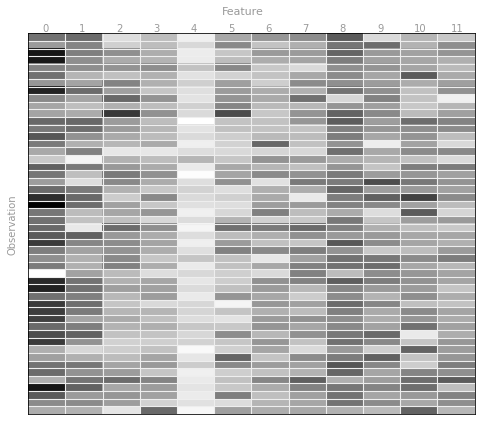

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from utilmti850 import prepareSubplot


# takeSample(withReplacement, num, [seed]) randomly selects num elements from the dataset with/without replacement, and has an
# optional seed parameter that one can set for reproducible results

data_values = (parsed_points_df
               .rdd
               .map(lambda lp: lp.features.toArray())
               .takeSample(False, 50, 47))

# You can uncomment the line below to see randomly selected features.  These will be randomly
# selected each time you run the cell because there is no set seed.  Note that you should run
# this cell with the line commented out when answering the lab quiz questions.
# data_values = (parsed_points_df
#                .rdd
#                .map(lambda lp: lp.features.toArray())
#                .takeSample(False, 50))

# generate layout and plot
fig, ax = prepareSubplot(
    np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7),
    hideLabels=True, gridColor='#eeeeee', gridWidth=1.1
)
image = ax.imshow(data_values,interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    ax.text(x, y, s, color='#999999', size='10')
ax.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
plt.show()

### (1c) Find the range

Now let's examine the labels to find the range of song years.  To do this, find the smallest and largest labels in the `parsed_points_df`.

We will use the min and max functions that are native to the DataFrames, and thus can be optimized using Spark's Catalyst Optimizer and Project Tungsten (don't worry about the technical details). This code will run faster than simply using the native min and max functions in Python. Use [selectExpr](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.selectExpr) to retrieve the min and max label values.

In [9]:
# TODO: Replace <FILL IN> with appropriate code

content_stats = parsed_points_df.select(parsed_points_df["label"].alias('year'))

min_year = content_stats.selectExpr("min(year)").collect()[0][0]

max_year = content_stats.selectExpr("max(year)").collect()[0][0]

print(min_year, max_year)

1922.0 2011.0


In [10]:
# TEST Find the range (1c)
testmti850.Test.assertEquals(len(parsed_points_df.first().features), 12,
                  'unexpected number of features in sample point')
sum_feat_two = parsed_points_df.rdd.map(lambda lp: lp.features[2]).sum()
testmti850.Test.assertTrue(np.allclose(sum_feat_two, 3158.96224351), 'parsedPointsDF has unexpected values')
year_range = max_year - min_year
testmti850.Test.assertTrue(year_range == 89, 'incorrect range for minYear to maxYear')

1 test passed.
1 test passed.
1 test passed.


### (1d) Shift labels

As we just saw, the labels are years in the 1900s and 2000s.  In learning problems, it is often natural to shift labels such that they start from zero.  Starting with `parsed_points_df`, create a new DataFrame in which the labels are shifted such that smallest label equals zero (hint: use `select`). After, use [withColumnRenamed](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumnRenamed) to rename the appropriate columns to `features` and `label`.

In [11]:
from pyspark.sql.functions import lit, col

# TODO: Replace <FILL IN> with appropriate code
parsed_data_df = (parsed_points_df.select("features", col("label") - min_year)
                                  .withColumnRenamed("(label - 1922.0)", "label"))

# View the first point
print('\n{0}'.format(parsed_data_df.first()))


Row(features=DenseVector([0.8841, 0.6105, 0.6005, 0.4747, 0.2472, 0.3573, 0.3441, 0.3396, 0.6009, 0.4257, 0.6049, 0.4192]), label=79.0)


In [12]:
# TEST Shift labels (1d)
old_sample_features = parsed_points_df.first().features
new_sample_features = parsed_data_df.first().features
testmti850.Test.assertTrue(np.allclose(old_sample_features, new_sample_features),
                'new features do not match old features')
sum_feat_two = parsed_data_df.rdd.map(lambda lp: lp.features[2]).sum()
testmti850.Test.assertTrue(np.allclose(sum_feat_two, 3158.96224351), 'parsed_data_df has unexpected values')
min_year_new = parsed_data_df.groupBy().min('label').first()[0]
max_year_new = parsed_data_df.groupBy().max('label').first()[0]
testmti850.Test.assertTrue(min_year_new == 0, 'incorrect min year in shifted data')
testmti850.Test.assertTrue(max_year_new == 89, 'incorrect max year in shifted data')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### Visualization 2: Shifting labels

We will look at the labels before and after shifting them. Both scatter plots below visualize tuples storing:

* a label value and
* the number of training points with this label.

The first scatter plot uses the initial labels, while the second one uses the shifted labels.  Note that the two plots look the same except for the labels on the x-axis.

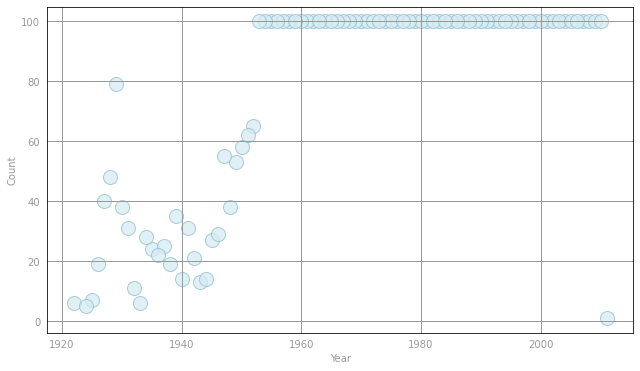

In [13]:
# from operator import add

# get data for plot
old_data = (parsed_points_df
             .rdd
             .map(lambda lp: (lp.label, 1))
             .reduceByKey(lambda x, y: x + y) # alternatively, one can use the operator add 
             .collect())                      # instead of the lambda func.
x, y = zip(*old_data)

# generate layout and plot data
fig, ax = prepareSubplot(np.arange(1920, 2050, 20), np.arange(0, 150, 20))
ax.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year')
ax.set_ylabel('Count')
plt.show()

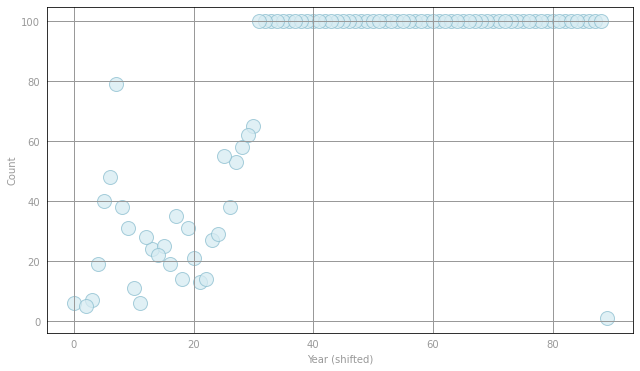

In [14]:
# get data for plot
new_data = (parsed_data_df
             .rdd
             .map(lambda lp: (lp.label, 1))
             .reduceByKey(lambda x, y: x + y)
             .collect())
x, y = zip(*new_data)

# generate layout and plot data
fig, ax = prepareSubplot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year (shifted)')
ax.set_ylabel('Count')
plt.show()

### (1e) Training, validation, and test sets

We're almost done parsing our dataset, and our final task involves spliting the dataset into training, validation and test sets. Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) with the specified weights and seed to create DataFrames storing each of these datasets. Next, cache each of these DataFrames, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset and verify that the sum of their sizes equals the value computed in Part (1a).

In [15]:
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 42

parsed_train_data_df, parsed_val_data_df, parsed_test_data_df = parsed_data_df.randomSplit(weights=weights, seed=seed)

parsed_train_data_df.cache()

parsed_val_data_df.cache()

parsed_test_data_df.cache()

n_train = parsed_train_data_df.count()

n_val = parsed_val_data_df.count()

n_test = parsed_test_data_df.count()

print(n_train, n_val, n_test, n_train + n_val + n_test)
print(parsed_data_df.count())

5437 612 675 6724
6724


In [16]:
# TEST Training, validation, and test sets (1e)
testmti850.Test.assertEquals(len(parsed_train_data_df.first().features), 12,
                  'parsed_train_data_df has wrong number of features')
sum_feat_two = (parsed_train_data_df
                 .rdd
                 .map(lambda lp: lp.features[2])
                 .sum())
sum_feat_three = (parsed_val_data_df
                  .rdd
                  .map(lambda lp: lp.features[3])
                  .reduce(lambda x, y: x + y))
sum_feat_four = (parsed_test_data_df
                  .rdd
                  .map(lambda lp: lp.features[4])
                  .reduce(lambda x, y: x + y))
testmti850.Test.assertTrue(np.allclose([sum_feat_two, sum_feat_three, sum_feat_four],
                            2526.87757656, 297.340394298, 184.235876654),
                'parsed Train, Val, Test data has unexpected values')
testmti850.Test.assertTrue(n_train + n_val + n_test == 6724, 'unexpected Train, Val, Test data set size')

testmti850.Test.assertEquals(n_train, 5437, 'unexpected value for nTrain')

testmti850.Test.assertEquals(n_val, 612, 'unexpected value for nVal')

testmti850.Test.assertEquals(n_test, 675, 'unexpected value for nTest')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


## Part 2: Create and evaluate a baseline model

### (2a) Average label

A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value.  Compute this value, which is the average (shifted) song year for the training set.  Use `selectExpr` and `first()` from the [DataFrame API](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame).

In [17]:
# TODO: Replace <FILL IN> with appropriate code

average_train_year = parsed_train_data_df.selectExpr("avg(label)").first()[0]

print(average_train_year)

53.59518116608424


**Expected value**: `53.54919992643001`, **my result**: `53.59518116608424`\
**Difference**: `0.04598123965422474`  --> `0.086%`

In [18]:
# TEST Average label (2a)
testmti850.Test.assertTrue(
    np.allclose(average_train_year, 53.59518116608424), 'incorrect value for average_train_year'
)

1 test passed.


### (2b) Root mean squared error

We naturally would like to see how well this naive baseline performs.  We will use root mean squared error ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)) for evaluation purposes.  Using [Regression Evaluator](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator),  compute the RMSE given a dataset of _(prediction, label)_ tuples.

In [19]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.ml.evaluation import RegressionEvaluator

preds_and_labels = [(1., 3.), (2., 1.), (2., 2.)]

preds_and_labels_df = spark.createDataFrame(preds_and_labels, ["prediction", "label"])

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

def calc_RMSE(dataset):
    """Calculates the root mean squared error for an dataset of (prediction, label) tuples.

    Args:
        dataset (DataFrame of (float, float)): A `DataFrame` consisting of (prediction, label) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return evaluator.evaluate(dataset)

example_rmse = calc_RMSE(preds_and_labels_df)

print(example_rmse)
# RMSE = sqrt[((1-3)^2 + (2-1)^2 + (2-2)^2) / 3] = 1.291

1.2909944487358058


In [20]:
testmti850.Test.assertTrue(np.allclose(example_rmse, 1.2909944487358058), 'incorrect value for exampleRMSE')

1 test passed.


### (2c) Training, validation and test RMSE

Now let's calculate the training, validation and test RMSE of our baseline model. To do this, first create DataFrames of _(prediction, label)_ tuples for each dataset, and then call `calc_RMSE()`. Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of number of years). You can use [createDataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SQLContext.createDataFrame) to make a DataFrame with the column names of "prediction" and "label" from an RDD.

In [21]:
# TODO: Replace <FILL IN> with appropriate code

# Here I use the average shifted year as the prediction, then convert it to RDD
preds_and_labels_train = (parsed_train_data_df.select('label')
                                              .withColumn('prediction', lit(average_train_year))
                                              .rdd)

preds_and_labels_train_df = spark.createDataFrame(preds_and_labels_train, ["label", "prediction"])

rmse_train_base = calc_RMSE(preds_and_labels_train_df)


preds_and_labels_val = (parsed_val_data_df.select('label')
                                          .withColumn('prediction', lit(average_train_year))
                                          .rdd)

preds_and_labels_val_df = spark.createDataFrame(preds_and_labels_val, ["label", "prediction"])

rmse_val_base = calc_RMSE(preds_and_labels_val_df)


preds_and_labels_test = (parsed_test_data_df.select('label')
                                            .withColumn('prediction', lit(average_train_year))
                                            .rdd)

preds_and_labels_test_df = spark.createDataFrame(preds_and_labels_test, ["label", "prediction"])

rmse_test_base = calc_RMSE(preds_and_labels_test_df)

print('Baseline Train RMSE = {0:.3f}'.format(rmse_train_base))
print('Baseline Validation RMSE = {0:.3f}'.format(rmse_val_base))
print('Baseline Test RMSE = {0:.3f}'.format(rmse_test_base))

Baseline Train RMSE = 21.466
Baseline Validation RMSE = 21.159
Baseline Test RMSE = 21.271


**Expected value**: `[21.598132, 20.759189, 20.546997]`, **my result**: `[21.466417064061876, 21.159492901731717, 21.27108361796124]`\
**Difference**: `[0.132132, -0.4, -0.724003]`

In [22]:
# TEST Training, validation and test RMSE (2c)
testmti850.Test.assertTrue(
    np.allclose(
        [rmse_train_base, rmse_val_base, rmse_test_base],
        [21.466417064061876, 21.159492901731717, 21.27108361796124]
    ),
    'incorrect RMSE values'
)

1 test passed.


### Visualization 3: Predicted vs. actual

We will visualize predictions on the validation dataset. The scatter plots below visualize tuples storing i) the predicted value and ii) true label.  The first scatter plot represents the ideal situation where the predicted value exactly equals the true label, while the second plot uses the baseline predictor (i.e., `average_train_year`) for all predicted values.  Further note that the points in the scatter plots are color-coded, ranging from light yellow when the true and predicted values are equal to bright red when they drastically differ.

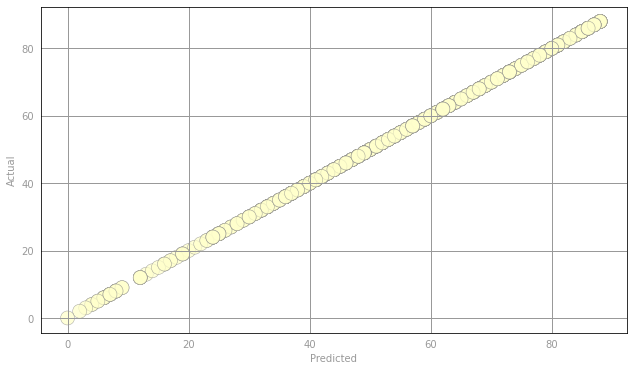

In [23]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

def squared_error(label, prediction):
    """Calculates the squared error for a single prediction."""
    return float((label - prediction)**2)

actual = np.asarray(parsed_val_data_df
                    .select('label')
                    .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda lp: squared_error(lp[0], lp[1]))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:, :3]

fig, ax = prepareSubplot(np.arange(0, 100, 20), np.arange(0, 100, 20))
ax.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

**Modification** Line 11:\
\
`.map(lambda lp: (lp.label, average_train_year['avg(label)']))`\
is changed to:\
`.map(lambda lp: (lp.label, average_train_year))`\

average_train_year is a **double**, not a **data frame** that contains average number

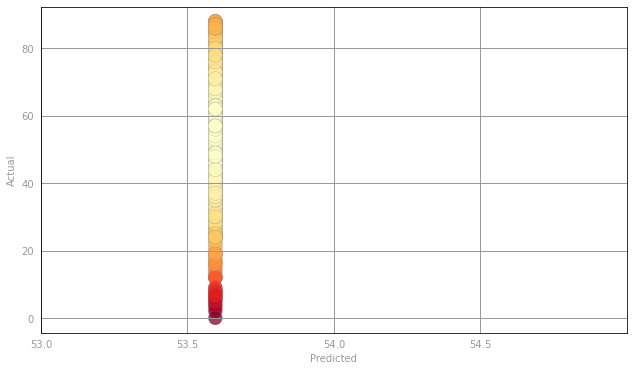

In [24]:
def squared_error(label, prediction):
    """Calculates the squared error for a single prediction."""
    return float((label - prediction) ** 2)

predictions = np.asarray(parsed_val_data_df
                         .rdd
                         .map(lambda lp: average_train_year)
                         .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                  #.map(lambda lp: (lp.label, average_train_year['avg(label)']))
                   .map(lambda lp: (lp.label, average_train_year))
                   .map(lambda lp: squared_error(lp[0], lp[1]))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:, : 3]

fig, ax = prepareSubplot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
ax.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

## Part 3: Train (via gradient descent) and evaluate a linear regression model

### (3a) Gradient summand

Now let's see if we can do better via linear regression, training a model via gradient descent (we'll omit the intercept for now). Recall that the gradient descent update for linear regression is:
\\[ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.\\]
where \\( \scriptsize i \\) is the iteration number of the gradient descent algorithm, and \\( \scriptsize j \\) identifies the observation.

First, implement a function that computes the summand for this update, i.e., the summand equals \\( \scriptsize (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \, ,\\) and test out this function on two examples.  Use the `DenseVector` [dot](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector.dot) method.

In [25]:
from pyspark.mllib.linalg import DenseVector

In [26]:
# TODO: Replace <FILL IN> with appropriate code
def gradient_summand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    # In the formula above, the part in the sum: (wi * xj - yj) * xj
    return lp.features * (weights.T.dot(lp.features) - lp.label)
    

example_w = DenseVector([1, 1, 1])
example_lp = LabeledPoint(2.0, [3, 1, 4])
# gradient_summand = (dot([1 1 1], [3 1 4]) - 2) * [3 1 4] = (8 - 2) * [3 1 4] = [18 6 24]
summand_one = gradient_summand(example_w, example_lp)
print(summand_one)

example_w = DenseVector([.24, 1.2, -1.4])
example_lp = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summand_two = gradient_summand(example_w, example_lp)
print(summand_two)

[18.0,6.0,24.0]
[1.7304000000000002,-5.191200000000001,-2.5956000000000006]


In [27]:
# TEST Gradient summand (3a)
testmti850.Test.assertTrue(np.allclose(summand_one, [18., 6., 24.]), 'incorrect value for summand_one')
testmti850.Test.assertTrue(np.allclose(summand_two, [1.7304,-5.1912,-2.5956]), 'incorrect value for summand_two')

1 test passed.
1 test passed.


### (3b) Use weights to make predictions

Next, implement a `get_labeled_predictions` function that takes in weights and an observation's `LabeledPoint` and returns a _(prediction, label)_ tuple.  Note that we can predict by computing the dot product between weights and an observation's features.

In [28]:
# TODO: Replace <FILL IN> with appropriate code
def get_labeled_prediction(weights, observation):
    """Calculates predictions and returns a (prediction, label) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (prediction, label) tuple. Convert the return type of the label and prediction to a float.
    """
    # the dot product between weights and an observation's features
    prediction_val = float(weights.dot(observation.features))
    # label is unchanged
    return (prediction_val, observation.label)

weights = np.array([1.0, 1.5])

prediction_example = spark.sparkContext.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                     LabeledPoint(1.5, np.array([.5, .5]))])

preds_and_labels_example = prediction_example.map(lambda lp: get_labeled_prediction(weights, lp))

print(preds_and_labels_example.collect())

[(1.75, 2.0), (1.25, 1.5)]


In [29]:
# TEST Use weights to make predictions (3b)
testmti850.Test.assertTrue(isinstance(preds_and_labels_example.first()[0], float), 'prediction must be a float')
testmti850.Test.assertEquals(preds_and_labels_example.collect(), [(1.75, 2.0), (1.25, 1.5)],
                  'incorrect definition for getLabeledPredictions')

1 test passed.
1 test passed.


### (3c) Gradient descent
Next, implement a gradient descent function for linear regression and test out this function on an example.

In [30]:
# TODO: Replace <FILL IN> with appropriate code

def linreg_gradient_descent(train_data, num_iters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        train_data (RDD of LabeledPoint): The labeled data for use in training the model.
        num_iters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    
    # The length of the training data
    n = train_data.count()
    
    # The number of features in the training data
    d = len(train_data.first().features)
    w = np.zeros(d)
    alpha = 1.0
    
    # We will compute and store the training error after each iteration
    error_train = np.zeros(num_iters)
    for i in range(num_iters):
        # Use get_labeled_prediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        
        preds_and_labels_train = train_data.map(lambda x: get_labeled_prediction(w, x))   # <FILL IN>
        
        preds_and_labels_train_df = spark.createDataFrame(preds_and_labels_train, ["prediction", "label"])
        
        error_train[i] = calc_RMSE(preds_and_labels_train_df)

        # Calculate the `gradient`.  Make use of the `gradient_summand` function you wrote in (3a).
        # Note that `gradient` should be a `DenseVector` of length `d`.
        
        # Calculate each summand then sum them up to get the gradient
        gradient = DenseVector(train_data.map(lambda x: gradient_summand(w, x))
                                         .sum())                # <FILL IN>
  
        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i + 1))
        
        # Update w:  wi+1 = wi - ai * sum(gradient)
        w -= gradient * alpha_i                     # <FILL IN>
        
    return w, error_train

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linreg_gradient_descent is working properly
example_n = 10
example_d = 3
example_data = (
    spark
    .sparkContext
    .parallelize(parsed_train_data_df.take(example_n))
    .map(lambda lp: LabeledPoint(lp.label, lp.features[0:example_d]))
)
print(example_data.take(2))

example_num_iters = 5
example_weights, example_error_train = linreg_gradient_descent(example_data, example_num_iters)

 # example_data.collect()
# print(linreg_gradient_descent(example_data, example_num_iters))  
    
print(example_weights)
print(example_error_train)

[LabeledPoint(59.0, [0.0,0.696269780071,0.395207288435]), LabeledPoint(5.0, [0.0120378089378,0.582288350082,0.347583622992])]
[ 4.33247264 33.15818324 17.87338995]
[43.34166587 36.99254897 34.47990014 33.12921281 32.30150161]


**I manually calculated the first component of weights and errors, I got similar values (same magnitude): 4.5 vs 4.3,  40.8 vs 43.3**\
**So I think I wrote this function correctly...**
**Plus, later in the calculation with this function, I got results within a relatively small margin of error, in the same magnitude**\
\
**Weights expected value**: `[0.59874548, 0.16755145, 1.19239355]`, **my result**: `[4.33247264 33.15818324 17.87338995]`\
**Difference**: `[-3.73372716, -32.99063179, -16.6809964]`

**Errors expected value**: `[1.73205081, 1.3096377, 1.27962073, 1.26123272, 1.24682059]`, **my result**: `[43.34166587 36.99254897 34.47990014 33.12921281 32.30150161]`\
**Difference**: `[-41.60961506, -35.68291127, -33.20027941]`

In [31]:
# TEST Gradient descent (3c)
expected_output = [4.33247264, 33.15818324, 17.87338995]
testmti850.Test.assertTrue(np.allclose(example_weights, expected_output), 'value of example_weights is incorrect')
expected_error = [43.34166587, 36.99254897, 34.47990014, 33.12921281, 32.30150161]
testmti850.Test.assertTrue(np.allclose(example_error_train, expected_error),
                'value of exampleErrorTrain is incorrect')

1 test passed.
1 test passed.


### (3d) Train the model
 
Now let's train a linear regression model on all of our training data and evaluate its accuracy on the validation set.  Note that the test set will not be used here.  If we evaluated the model on the test set, we would bias our final results.
 
We've already done much of the required work: we computed the number of features in Part (1b); we created the training and validation datasets and computed their sizes in Part (1e); and, we wrote a function to compute RMSE in Part (2b).

In [32]:
# TODO: Replace <FILL IN> with appropriate code
num_iters = 50

weights_LR0, error_train_LR0 = linreg_gradient_descent(parsed_train_data_df.rdd, num_iters)
print(weights_LR0)

[22.37369015 20.61199637 -0.38237943  8.13420067  5.75874955 -4.43935733
 15.52273264  3.96785678  9.91615892  5.90397265 10.89251975  3.85231056]


In [33]:
# Use the validation data to get RMSE
preds_and_labels = parsed_val_data_df.rdd.map(lambda lp: get_labeled_prediction(weights_LR0, lp))

preds_and_labels_df = spark.createDataFrame(preds_and_labels, ["prediction", "label"])

rmse_val_LR0 = calc_RMSE(preds_and_labels_df)

print('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmse_val_base, rmse_val_LR0))

Validation RMSE:
	Baseline = 21.159
	LR0 = 18.627


**Expected value**: `[22.63418505, 20.64417482, -0.39044365, 8.37584137, 5.82628346, -4.73184863, 15.76496428,
                   3.6353787, 9.87147047, 5.80887121, 11.0129383, 3.48020694]`\
**my result**:      `[22.37369015, 20.61199637, -0.38237943,  8.13420067,  5.75874955, -4.43935733,
                   15.52273264,  3.96785678,  9.91615892,  5.90397265, 10.89251975,  3.85231056]`\
**Difference**: `[0.2604948962428253, 0.032178448870794796, -0.008064218353688701, 0.24164069943747535, 0.06753390931914893, -0.2924912994137907, 0.2422316421556605, -0.3324780753734111, -0.0446884543492434, -0.09510144192528269, 0.12041854836016164, -0.3721036223299623]`

In [34]:
# TEST Train the model (3d)
expected_output = [22.37369015, 20.61199637, -0.38237943,  8.13420067,  5.75874955, -4.43935733,
                   15.52273264,  3.96785678,  9.91615892,  5.90397265, 10.89251975,  3.85231056]
testmti850.Test.assertTrue(np.allclose(weights_LR0, expected_output), 'incorrect value for weights_LR0')

1 test passed.


### Visualization 4: Training error
 
We will look at the log of the training error as a function of iteration. The first scatter plot visualizes the logarithm of the training error for all 50 iterations.  The second plot shows the training error itself, focusing on the final 44 iterations.

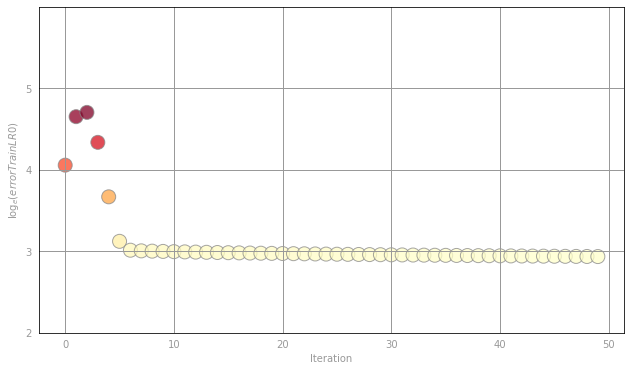

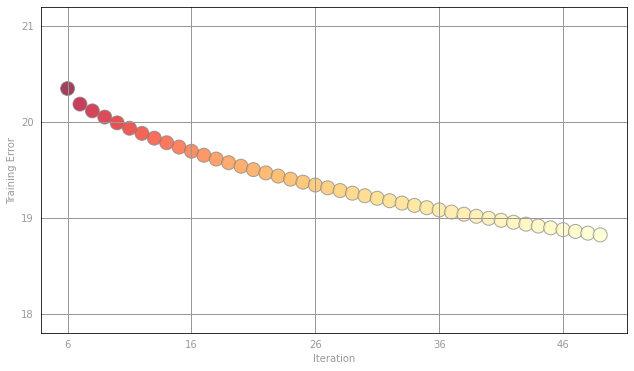

In [35]:
norm = Normalize()

clrs = cmap(np.asarray(norm(np.log(error_train_LR0))))[:,0:3]

fig, ax = prepareSubplot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
ax.scatter(range(0, num_iters), np.log(error_train_LR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
plt.show((fig))

norm = Normalize()

clrs = cmap(np.asarray(norm(error_train_LR0[6:])))[:,0:3]

fig, ax = prepareSubplot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
ax.scatter(range(0, num_iters - 6), error_train_LR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration')
ax.set_ylabel(r'Training Error')
plt.show()

## Part 4: Train using SparkML and perform grid search

### (4a) `LinearRegression`

We're already doing better than the baseline model, but let's see if we can do better by adding an intercept, using regularization, and (based on the previous visualization) training for more iterations.  SparkML's [LinearRegression](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression) essentially implements the same algorithm that we implemented in Part (3b), albeit more efficiently and with various additional functionality, such as including an intercept in the model and allowing L1, L2, or [elastic net regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization). Elastic net regularization is a linear combination of L1 and L2 regularization. For $\alpha = 0$, the penalty is an L2 penalty. For $\alpha = 1$, it is an L1 penalty.

First use LinearRegression to train a model with [elastic net](https://spark.apache.org/docs/1.6.1/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression.elasticNetParam) regularization and an intercept.  This method returns a [LinearRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel).  Next, use the model's [coefficients](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegressionModel.coefficients) (weights) and [intercept](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegressionModel.intercept) attributes to print out the model's parameters.

In [36]:
from pyspark.ml.regression import LinearRegression

# Values to use when training the linear regression model
num_iters = 500  # iterations
reg = 1e-1  # regParam
alpha = .2  # elasticNetParam
use_intercept = True  # intercept

In [37]:
from pyspark.ml.feature import VectorAssembler
import pandas as pd

def convert_model_df(parsed_train_data_df):
    """Somehow the parsed_train_data_df can't be used directly by the LinearRegression
        The type of the feature column is incompatible
        So here I convert it to another dataframe and use a VectorAssembler on it
        Then the LinearRegression can use the output dataframe
    """
    # Or use MLUtils.convertVectorColumnsToML(parsed_train_data_df, 'features')
    input_dim = len(parsed_train_data_df.first()[0])
    _all_train = []
    for elt in parsed_train_data_df.collect():
        data_list = []
        data_list = (elt[1],)
        for x in elt[0]:
            data_list += (x, )
        _all_train.append(data_list)
        
    pandas_df = pd.DataFrame(_all_train)
    converted_spark = spark.createDataFrame(pandas_df)
    vecAssembler = VectorAssembler(inputCols=[str(x + 1) for x in range(input_dim)], outputCol='vecfeatures')
    return vecAssembler.transform(converted_spark).select(col('0').alias('label'), col('vecfeatures').alias('features'))

parsed_train_data_df = convert_model_df(parsed_train_data_df)
parsed_train_data_df.cache()
parsed_train_data_df.limit(5).toPandas().head()
# convert_model_df(parsed_train_data_df).printSchema()

,label,features
0,59.0,"[0.0, 0.696269780071, 0.395207288435, 0.360177..."
1,5.0,"[0.0120378089378, 0.582288350082, 0.3475836229..."
2,62.0,"[0.0303558512787, 0.264323620293, 0.0, 0.00684..."
3,35.0,"[0.0305925311676, 0.402530811194, 0.2961966259..."
4,62.0,"[0.0360221885556, 0.361671498224, 0.3318796005..."


In [38]:
# TODO: Replace <FILL IN> with appropriate code

my_lin_reg =LinearRegression(featuresCol='features', labelCol='label', 
                             maxIter=num_iters, regParam=reg,
                             elasticNetParam=alpha, fitIntercept=use_intercept)

first_model = my_lin_reg.fit(parsed_train_data_df)

# coeffsLR1 stores the model coefficients; interceptLR1 stores the model intercept

coeffs_LR1 = first_model.coefficients

intercept_LR1 = first_model.intercept

print(coeffs_LR1, intercept_LR1)

[23.11023892358343,26.226557124703103,-67.09412511360203,51.12166662743235,-11.91352651152115,-48.1386082341282,37.425659560025935,-21.81528461027397,0.11694539738336449,-2.7544959109033442,-10.957848572922764,-11.630833998851976] 64.60832184961164


**Expected intercept value**: `66.92674875888055`\
**my result**:      `64.60832184961164`\
**Difference**: `2.318426909268908`

**Expected weights value**: `[23.198263802857262,26.985045231303086, -67.73180097557017, 52.581253053539314, 
                   -12.602263525139243, -48.387783459857786, 36.41656162742487, -23.607292395355707,
                    0.0,-3.0108595511539082,-10.606012321268773,-14.977614644741806]`\
**my result**: `[23.11023892358343,26.226557124703103,-67.09412511360203,51.12166662743235,-11.91352651152115,
                  -48.1386082341282,37.425659560025935,-21.81528461027397,0.11694539738336449,
                  -2.7544959109033442,-10.957848572922764,-11.630833998851976]`\
**Difference**: `[0.0880248792738314, 0.7584881065999838, -0.637675861968134, 1.4595864261069664, 
                -0.688737013618093, -0.24917522572958717, -1.0090979326010654, -1.7920077850817364,
                -0.11694539738336449, -0.256363640250564, 0.3518362516539906, -3.3467806458898295]`

In [39]:
# TEST LinearRegression (4a)
expected_intercept = 64.60832184961164
expected_weights = [23.11023892358343,26.226557124703103,-67.09412511360203,51.12166662743235,
                    -11.91352651152115,-48.1386082341282,37.425659560025935,-21.81528461027397,
                    0.11694539738336449,-2.7544959109033442,-10.957848572922764,-11.630833998851976]
testmti850.Test.assertTrue(np.allclose(intercept_LR1, expected_intercept), 'incorrect value for intercept_LR1')
testmti850.Test.assertTrue(np.allclose(coeffs_LR1, expected_weights), 'incorrect value for weights_LR1')

1 test passed.
1 test passed.


### (4b) Transform

Now use the [LinearRegressionModel.transform()](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegressionModel.transform) method to make predictions
on the `parsed_train_data_df`.

In [40]:
# TODO: Replace <FILL IN> with appropriate code

sample_prediction = first_model.transform(parsed_train_data_df)

sample_prediction.show()

+-----+--------------------+------------------+
|label|            features|        prediction|
+-----+--------------------+------------------+
| 59.0|[0.0,0.6962697800...| 38.01175507020871|
|  5.0|[0.0120378089378,...|51.644438506931316|
| 62.0|[0.0303558512787,...|39.845359841321496|
| 35.0|[0.0305925311676,...|  44.7069876796122|
| 62.0|[0.0360221885556,...| 34.51644819230805|
| 35.0|[0.0699897994647,...|43.763860150324305|
|  6.0|[0.0818546971883,...| 39.36797830218609|
| 35.0|[0.0877822407675,...| 49.56867188532526|
|  6.0|[0.10320837371,0....|31.889258142283204|
| 62.0|[0.107048719513,0...| 49.08549448473801|
|  6.0|[0.110369105352,0...| 36.19047890900821|
|  7.0|[0.112416325075,0...| 32.27511127477054|
| 35.0|[0.115539028023,0...|38.177241200914786|
| 35.0|[0.117417506022,0...|41.027728303752426|
| 62.0|[0.121345656384,0...|57.852613119180305|
| 84.0|[0.12476071418,0....|61.958747850660814|
| 40.0|[0.126361798443,0...| 52.04125679209059|
| 68.0|[0.129940202152,0...| 57.47424987

**Expected value**: `21.084909469789665`\
**my result**:      `38.01175507020871`\
**Difference**: `16.926845600419043`

In [41]:
# TEST Predict (4b)
testmti850.Test.assertTrue(np.allclose(sample_prediction.first().prediction, 38.01175507020871),
                'incorrect value for sample_prediction')

1 test passed.


### (4c) Evaluate RMSE

Next evaluate the accuracy of this model on the validation set.  Use the `transform()` method to create predictions, and then use the `calc_RMSE()` function from Part (2b).

In [42]:
# Convert the validation data, then cache it
parsed_val_data_df = convert_model_df(parsed_val_data_df)
parsed_val_data_df.cache()

DataFrame[label: double, features: vector]

In [43]:
# TODO: Replace <FILL IN> with appropriate code
val_pred_df = first_model.transform(parsed_val_data_df)

rmse_val_LR1 = calc_RMSE(val_pred_df)

print ('Validation RMSE:\n\tBaseline = {0:.3f} \n\tLR0 = {1:.3f}\n\tLR1 = {2:.4f}'
        .format(rmse_val_base, rmse_val_LR0, rmse_val_LR1))

Validation RMSE:
	Baseline = 21.159 
	LR0 = 18.627
	LR1 = 15.3864


**Expected value**: `16.115204285984859`\
**my result**:      `15.386381061973946`\
**Difference**: `0.7288232240109132`

In [44]:
# TEST Evaluate RMSE (4c)
testmti850.Test.assertTrue(np.allclose(rmse_val_LR1, 15.386381061973946), 'incorrect value for rmseValLR1')

1 test passed.


### (4d) Grid search

We're already outperforming the baseline on the validation set by almost 2 years on average, but let's see if we can do better. Perform grid search to find a good regularization parameter.  Try `regParam` values `1e-10`, `1e-5`, and `1.0`.

In [45]:
# TODO: Replace <FILL IN> with appropriate code
best_RMSE = rmse_val_LR1
best_reg_param = reg
best_model = first_model

num_iters = 500  # iterations
alpha = .2  # elasticNetParam
use_intercept = True  # intercept

regParams = [1e-10, 1e-5, 1.0]

for reg in regParams:
    lin_reg = LinearRegression(maxIter=num_iters, regParam=reg, elasticNetParam=alpha, fitIntercept=use_intercept)
    model = lin_reg.fit(parsed_train_data_df)
    val_pred_df = model.transform(parsed_val_data_df)

    rmse_val_grid = calc_RMSE(val_pred_df)
    print(rmse_val_grid)

    if rmse_val_grid < best_RMSE:
        best_RMSE = rmse_val_grid
        best_reg_param = reg
        best_model = model

rmse_val_LR_grid = best_RMSE

15.381803044741753
15.381803677627985
15.436346812639732


**Expected value**: `16.097420376208206`\
**my result**:      `15.381803044741753`\
**Difference**: `0.7156173314664525`

In [46]:
# TEST Grid search (4d)
testmti850.Test.assertTrue(np.allclose(15.381803044741753, rmse_val_LR_grid), 'incorrect value for rmseValLRGrid')

1 test passed.


### Visualization 5: Best model's predictions

Next, we create a visualization similar to 'Visualization 3: Predicted vs. actual' from Part 2 using the predictions from the best model from Part (4d) on the validation dataset.  Specifically, we create a color-coded scatter plot visualizing tuples storing i) the predicted value from this model and ii) true label.

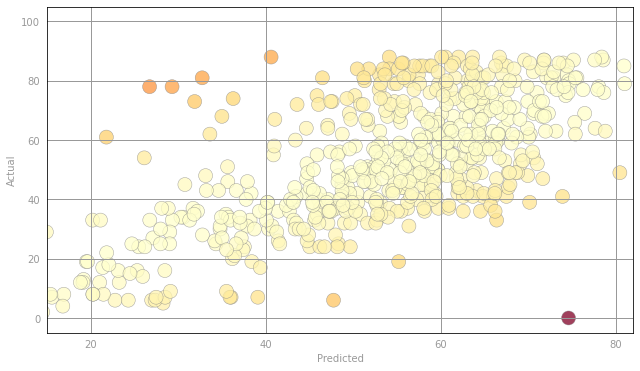

In [47]:
parsed_val_df = best_model.transform(parsed_val_data_df)
predictions = np.asarray(parsed_val_df
                         .select('prediction')
                         .collect())
actual = np.asarray(parsed_val_df
                      .select('label')
                      .collect())
error = np.asarray(parsed_val_df
                     .rdd
                     .map(lambda lp: squared_error(lp.label, lp.prediction))
                     .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepareSubplot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
ax.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted')
ax.set_ylabel(r'Actual')
plt.show()

### Visualization 6: Hyperparameter heat map

Next, we perform a visualization of hyperparameter search using a larger set of hyperparameters (with precomputed results).  Specifically, we create a heat map where the brighter colors correspond to lower RMSE values.  The first plot has a large area with brighter colors.  In order to differentiate within the bright region, we generate a second plot corresponding to the hyperparameters found within that region.

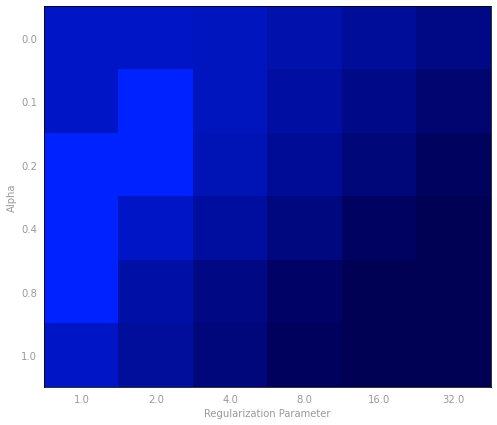

In [48]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results, to save the time required to run 36 models
num_iters = 500
reg_params = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
alpha_params = [0.0, .1, .2, .4, .8, 1.0]
rmse_val = np.array([[ 15.317156766552452, 15.327211561989827, 15.357152971253697, 15.455092206273847, 15.73774335576239,
                       16.36423857334287, 15.315019185101972, 15.305949211619886, 15.355590337955194, 15.573049001631558,
                       16.231992712117222, 17.700179790697746, 15.305266383061921, 15.301104931027034, 15.400125020566225,
                       15.824676190630191, 17.045905140628836, 19.365558346037535, 15.292810983243772, 15.333756681057828,
                       15.620051033979871, 16.631757941340428, 18.948786862836954, 20.91796910560631, 15.308301384150049,
                       15.522394576046239, 16.414106221093316, 18.655978799189178, 20.91796910560631, 20.91796910560631,
                       15.33442896030322, 15.680134490745722, 16.86502909075323, 19.72915603626022, 20.91796910560631,
                       20.91796910560631 ]])

num_rows, num_cols = len(alpha_params), len(reg_params)
rmse_val = np.array(rmse_val)
rmse_val.shape = (num_rows, num_cols)

fig, ax = prepareSubplot(np.arange(0, num_cols, 1), np.arange(0, num_rows, 1), figsize=(8, 7), hideLabels=True,
                       gridWidth=0.)
ax.set_xticklabels(reg_params), ax.set_yticklabels(alpha_params)
ax.set_xlabel('Regularization Parameter')
ax.set_ylabel('Alpha')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = ax.imshow(rmse_val,interpolation='nearest', aspect='auto', cmap=colors)
plt.show()

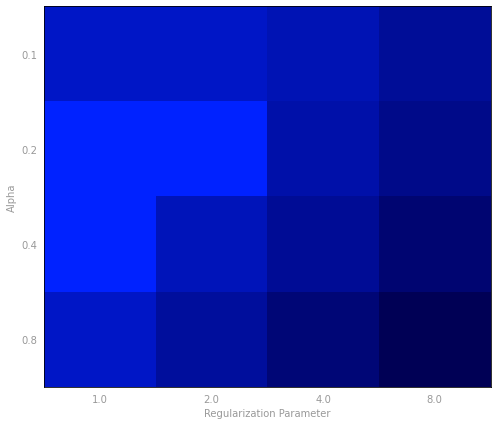

In [49]:
# Zoom into the top left
alpha_params_zoom, reg_params_zoom = alpha_params[1:5], reg_params[:4]
rmse_val_zoom = rmse_val[1:5, :4]

num_rows, num_cols = len(alpha_params_zoom), len(reg_params_zoom)

fig, ax = prepareSubplot(np.arange(0, num_cols, 1), np.arange(0, num_rows, 1), figsize=(8, 7), hideLabels=True,
                       gridWidth=0.)
ax.set_xticklabels(reg_params_zoom), ax.set_yticklabels(alpha_params_zoom)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Alpha')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmse_val_zoom, interpolation='nearest', aspect='auto', cmap=colors)
plt.show()

## Part 5: Add interactions between features

### (5a) Add 2-way interactions

So far, we've used the features as they were provided.  Now, we will add features that capture the two-way interactions between our existing features.  Write a function `two_way_interactions` that takes in a `LabeledPoint` and generates a new `LabeledPoint` that contains the old features and the two-way interactions between them.

> Note:
> * A dataset with three features would have nine ( \\( \scriptsize 3^2 \\) ) two-way interactions.
> * You might want to use [itertools.product](https://docs.python.org/2/library/itertools.html#itertools.product) to generate tuples for each of the possible 2-way interactions.
> * Remember that you can combine two `DenseVector` or `ndarray` objects using [np.hstack](http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html#numpy.hstack).

In [50]:
# TODO: Replace <FILL IN> with appropriate code
import itertools

def two_way_interactions(lp):
    """Creates a new `LabeledPoint` that includes two-way interactions.

    Note:
        For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these
        would be appended to the original [x, y] feature list.

    Args:
        lp (LabeledPoint): The label and features for this observation.

    Returns:
        LabeledPoint: The new `LabeledPoint` should have the same label as `lp`.  Its features
            should include the features from `lp` followed by the two-way interaction features.
    """
    # Two way products of the features 
    product_list = [elt[0] * elt[1] for elt in itertools.product(lp[1], lp[1])]
    # Add the old features after the two way features
    hstack_list = np.hstack((product_list, lp[1]))
    # Keep the same label
    return LabeledPoint(lp[0], hstack_list)

  
print(two_way_interactions((0.0, Vectors.dense([2, 3]))))

# Transform the existing train, validation, and test sets to include two-way interactions.
# Remember to convert them back to DataFrames at the end.

train_data_interact_df = parsed_train_data_df.rdd.map(lambda x: two_way_interactions(x)).toDF()

val_data_interact_df = parsed_val_data_df.rdd.map(lambda x: two_way_interactions(x)).toDF()

test_data_interact_df = parsed_test_data_df.rdd.map(lambda x: two_way_interactions((x[1], x[0]))).toDF()

(0.0,[4.0,6.0,6.0,9.0,2.0,3.0])


**Expected train_data_interact sum**: `39.623593682048714`\
**my result**:      `28.623429648737336`\
**Difference**: `11.000164033311378`

**Expected val_data_interact sum**: `44.30378025359034`\
**my result**:      `24.483493560389867`\
**Difference**: `19.820286693200472`

**Expected test_data_interact sum**: `47.55099918213616`\
**my result**:      `27.8222018049451`\
**Difference**: `19.72879737719106`

In [51]:
# TEST Add two-way interactions (5a)
two_way_example = two_way_interactions((0.0, Vectors.dense([2, 3])))
testmti850.Test.assertTrue(np.allclose(sorted(two_way_example.features),
                            sorted([2.0, 3.0, 4.0, 6.0, 6.0, 9.0])),
                'incorrect features generatedBy two_way_interactions')
two_way_point = two_way_interactions((1.0, Vectors.dense([1, 2, 3])))
testmti850.Test.assertTrue(np.allclose(sorted(two_way_point.features),
                            sorted([1.0,2.0,3.0,1.0,2.0,3.0,2.0,4.0,6.0,3.0,6.0,9.0])),
                'incorrect features generated by twoWayInteractions')
testmti850.Test.assertEquals(two_way_point.label, 1.0, 'incorrect label generated by two_way_interactions')
testmti850.Test.assertTrue(np.allclose(sum(train_data_interact_df.first().features), 28.623429648737336),
                'incorrect features in train_data_interact_df')

testmti850.Test.assertTrue(np.allclose(sum(val_data_interact_df.first().features), 24.483493560389867),
                'incorrect features in val_data_interact_df')

testmti850.Test.assertTrue(np.allclose(sum(test_data_interact_df.first().features), 27.8222018049451),
                'incorrect features in test_data_interact_df')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


### (5b) Build interaction model

Now, let's build the new model.  We've done this several times now.  To implement this for the new features, we need to change a few variable names.

 > Note:
 > * Remember that we should build our model from the training data and evaluate it on the validation data.
 > * You should re-run your hyperparameter search after changing features, as using the best hyperparameters from your prior model will not necessary lead to the best model.
 > * For this exercise, we have already preset the hyperparameters to reasonable values.

In [52]:
# Convert the interact training, validation, and test data 
converted_train_data_interact_df = convert_model_df(train_data_interact_df)
converted_train_data_interact_df.cache()
converted_val_data_interact_df = convert_model_df(val_data_interact_df)
converted_val_data_interact_df.cache()
converted_test_data_interact_df = convert_model_df(test_data_interact_df)
converted_test_data_interact_df.cache()

DataFrame[label: double, features: vector]

In [53]:
# TODO: Replace <FILL IN> with appropriate code
num_iters = 500
reg = 1e-10
alpha = .2
use_intercept = True

lin_reg = LinearRegression(maxIter=num_iters, regParam=reg, elasticNetParam=alpha, fitIntercept=use_intercept)

model_interact = lin_reg.fit(converted_train_data_interact_df)

preds_and_labels_interact_df = model_interact.transform(converted_val_data_interact_df)

rmse_val_interact = calc_RMSE(preds_and_labels_interact_df)

print ('Validation RMSE:\n\tBaseline = {0:.3f} \n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f} \n\tLRGrid = {3:.3f} \n\tLRInteract = {4:.3f}'.format(rmse_val_base, rmse_val_LR0, rmse_val_LR1,
                                                  rmse_val_LR_grid, rmse_val_interact))

Validation RMSE:
	Baseline = 21.159 
	LR0 = 18.627
	LR1 = 15.386 
	LRGrid = 15.382 
	LRInteract = 15.412


**Expected value**: `15.456123194017584`\
**my result**:      `15.411800831965058`\
**Difference**: `0.04432236205252593`

In [54]:
# TEST Build interaction model (5b)
testmti850.Test.assertTrue(np.allclose(rmse_val_interact, 15.411800831965058), 'incorrect value for rmse_val_interact')

1 test passed.


### (5c) Evaluate interaction model on test data

Our next step is to evaluate the new model on the test dataset.  Note that we haven't used the test set to evaluate any of our models.  Because of this, our evaluation provides us with an unbiased estimate for how our model will perform on new data.  If we had changed our model based on viewing its performance on the test set, our estimate of RMSE would likely be overly optimistic.

We'll also print the RMSE for both the baseline model and our new model.  With this information, we can see how much better our model performs than the baseline model.

In [55]:
# TODO: Replace <FILL IN> with appropriate code

preds_and_labels_test_df = model_interact.transform(converted_test_data_interact_df)

rmse_test_interact = calc_RMSE(preds_and_labels_test_df)

print ('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'
       .format(rmse_test_base, rmse_test_interact))

Test RMSE:
	Baseline = 21.271
	LRInteract = 15.063


**Expected value**: `14.700913996507659`\
**my result**:      `15.062675631670098`\
**Difference**: `-0.36176163516243953`

In [56]:
# TEST Evaluate interaction model on test data (5c)
testmti850.Test.assertTrue(np.allclose(rmse_test_interact, 15.062675631670098),
                'incorrect value for rmse_test_interact')

1 test passed.


### (5d) Use a pipeline to create the interaction model

Our final step is to create the interaction model using a [Pipeline](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.Pipeline).  Note that Spark contains the [PolynomialExpansion](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.PolynomialExpansion) transformer which will automatically generate interactions for us.  In this section, you'll need to generate the `PolynomialExpansion` transformer and set the stages for the `Pipeline` estimator.   Make sure to use a degree of 2 for `PolynomialExpansion`, set the input column appropriately, and set the output column to "polyFeatures".  The pipeline should contain two stages: the polynomial expansion and the linear regression.

In [57]:
# Convert the test data frame
parsed_test_data_df = convert_model_df(parsed_test_data_df)
parsed_test_data_df.cache()

DataFrame[label: double, features: vector]

In [58]:
# TODO: Replace <FILL IN> with appropriate code
from pyspark.ml import Pipeline
from pyspark.ml.feature import PolynomialExpansion

num_iters = 500
reg = 1e-10
alpha = .2
use_intercept = True

polynomial_expansion = PolynomialExpansion(degree=2, inputCol='features', outputCol='polyFeatures')

linear_regression = LinearRegression(maxIter=num_iters, regParam=reg, elasticNetParam=alpha,
                                     fitIntercept=use_intercept, featuresCol='polyFeatures')

pipeline = Pipeline(stages=[polynomial_expansion, linear_regression])

pipeline_model = pipeline.fit(parsed_train_data_df)

predictions_df = pipeline_model.transform(parsed_test_data_df)

evaluator = RegressionEvaluator()

rmse_test_pipeline = evaluator.evaluate(predictions_df, {evaluator.metricName: "rmse"})

print('RMSE for test data set using pipelines: {0:.3f}'.format(rmse_test_pipeline))

RMSE for test data set using pipelines: 15.073


**Expected value**: `14.67520761192023`\
**my result**:      `15.07274947894262`\
**Difference**: `-0.39754186702239025`

In [59]:
# TEST Use a pipeline to create the interaction model (5d)
testmti850.Test.assertTrue(np.allclose(rmse_test_pipeline, 15.07274947894262),
                'incorrect value for rmse_test_pipeline')

1 test passed.


### Notebook Ended